## Run phonopy calculations

In [1]:
%load_ext aiida
%aiida

Loaded AiiDA DB environment - profile name: 2.0-dev.

In [2]:
from pymatgen.core import Structure

In [3]:
from aiida_user_addons.common.inputset.vaspsets import VASPInputSet
from aiida_user_addons.vworkflows.relax  import VaspRelaxWorkChain, RelaxOptions
from aiida_user_addons.vworkflows.phonon_wc import VaspAutoPhononWorkChain

In [4]:
from aiida.orm import StructureData

In [5]:
nacl = StructureData(pymatgen=Structure.from_file("POSCAR.NaCl"))

In [6]:
nacl.store()

<StructureData: uuid: 273fe6bd-662c-4e93-9dfc-0d28cca4a528 (pk: 1115)>

In [38]:
builder = VaspAutoPhononWorkChain.get_builder()

In [8]:
!verdi plugin list aiida.workflows vaspu.phonopy

Description:

         VaspAutoPhononWorkChain      A workchain to perform automated relaxation followed by finite
    displacement     single point calculations and finally use phonopy to obtain the band structure
    and density of states.

Inputs:
         phonon_settings  Dict            Settings for the underlying phonopy calculations
             singlepoint  Data            Additional inputs for the singlepoint calculations.
               structure  StructureData   Structure of which the phonons should calculated
                metadata
                     nac  Data            Inputs for the DFPT NAC calculation.
                 options  Dict, NoneType  Options for the remote phonopy calculation
             phonon_code  Code, NoneType  Code for the phonopy for remote calculations
                   relax  Data            Inputs for the relaxation to be performed.
          remote_phonopy                  Run phonopy as a remote code.
    reuse_supercell_calc  Str, NoneType 

## Prepare the inputs

In [39]:
from aiida_user_addons.common.builder_updater import VaspAutoPhononUpdater, VaspRelaxUpdater, VaspBuilderUpdater

Setup phonon finite-displacement inputs

In [40]:
upd = VaspAutoPhononUpdater(builder)

In [41]:
upd.use_inputset(nacl, "UCLRelaxSet", overrides={'encut': 600, 'addgrid': True, 'ediff': 1e-7, 'lorbit': None, 'lvhar': None,
                                     'ncore': 8, 'ispin':1, 
                                     'ldauu_mapping': {'Ti': ['d', 0.0]}, 'magmom': None}
                )
upd.set_kspacing(0.05)
upd.set_code("vasp-6.2.0-vtst-std@kiwi-e")
upd.update_options(
    max_wallclock_seconds=3600,
)
upd.update_resources(
    num_machines=1,
    tot_num_mpiprocs=32,
)

Using input set file at: /home/bonan/aiida_envs/aiida-2.0-dev/aiida-user-addons/aiida_user_addons/common/inputset/UCLRelaxSet.yaml


/home/bonan/aiida_envs/aiida-2.0-dev/aiida-user-addons/aiida_user_addons/common/builder_updater.py:267: UserWarning: Using default options template - adjustment needed for the target computer
  warn(


We want to perofrm an initial relaxation - so need to setup that as well!

In [42]:
upd_relax = VaspRelaxUpdater(builder.relax, override_vasp_namespace=builder.relax.vasp, namespace_relax=builder.relax)

In [43]:
upd_relax.use_inputset(nacl, "UCLRelaxSet", overrides={'encut': 600, 'addgrid': True, 'ediff': 1e-7, 'lorbit': None, 'lvhar': None, "ncore":8, 'ispin': 1,
                                                        'ldauu_mapping': {'Ti': ['d', 0.0]}, 'magmom': None}
                )

Using input set file at: /home/bonan/aiida_envs/aiida-2.0-dev/aiida-user-addons/aiida_user_addons/common/inputset/UCLRelaxSet.yaml


In [44]:
upd_relax.update_options(max_wallclock_seconds=3600)
upd_relax.update_resources(num_machines=1, tot_num_mpiprocs=4)
upd_relax.set_kspacing(0.05)

upd_relax.update_relax_settings(force_cutoff=1e-3)
upd_relax.set_code("vasp-std@localhost")

upd_relax.update_options(
    max_wallclock_seconds=3600,
)
upd_relax.update_resources(
    num_machines=1,
    tot_num_mpiprocs=4,
)

NAC calculation inputs

In [45]:
upd_nac = VaspBuilderUpdater(builder.nac, root_namespace=builder)

upd_nac.use_inputset(nacl, "UCLRelaxSet", 
                          overrides={'encut': 600, 'addgrid': True, 'ediff': 1e-7, 'lorbit': None, 'lvhar': None,
                                     'ncore': None, 'ispin':1, 'lepsilon': True, 
                                     'ldauu_mapping': {'Ti': ['d', 0.0]}, 'magmom': None})

upd_nac.update_options(
    max_wallclock_seconds=3600,
)
upd_nac.update_resources(
    num_machines=1,
    tot_num_mpiprocs=4,
)
upd_nac.set_code("vasp-6.2.0-vtst-std@kiwi-e")


Using input set file at: /home/bonan/aiida_envs/aiida-2.0-dev/aiida-user-addons/aiida_user_addons/common/inputset/UCLRelaxSet.yaml


/home/bonan/aiida_envs/aiida-2.0-dev/aiida-user-addons/aiida_user_addons/common/builder_updater.py:267: UserWarning: Using default options template - adjustment needed for the target computer
  warn(


Phonon specific settings for phonopy

In [46]:
upd.builder.phonon_settings = Dict(dict={
    'supercell_matrix': [2, 2, 2],
    'mesh': 10,
    'primitive_matrix': 'auto'
})

In [47]:
upd.set_label('NaCl Phonon')

In [48]:
from aiida.engine import submit

In [49]:
builder.relax.vasp.code

<InstalledCode: Remote code 'vasp-std' on localhost pk: 301, uuid: da78d318-7e7a-4f17-810a-d6a74000b9f2>

In [51]:
submit(builder)

<WorkChainNode: uuid: 75f06ad1-9f3a-4d8b-8164-a35d7aee4d20 (pk: 1319) (aiida.workflows:vaspu.phonopy)>

## Analysis

In [52]:
work = load_node("75f06ad1")

Quick visualisation for the band structure

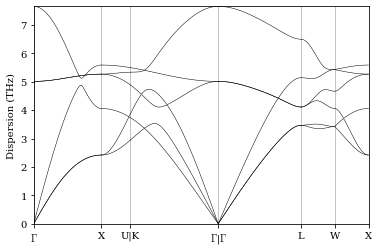

In [53]:
work.outputs.band_structure.show_mpl()

Plot the total density of states

In [54]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Total DOS (1/THz)')

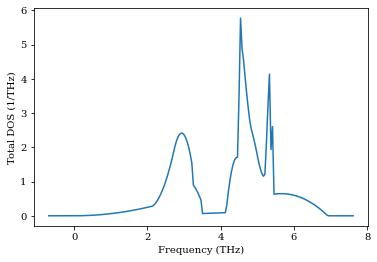

In [55]:
dos = work.outputs.dos
xlabel, x, xunit = dos.get_x()
ylabel, y, yunit = dos.get_y()[0]
plt.plot(x, y)
plt.xlabel(xlabel + f' ({xunit})')
plt.ylabel(ylabel + f' ({yunit})')

The *force constants* and *force sets* arrays can also be accessed - one can use them to redo phonon calculations with different setting using the phonopy Python API  

In [56]:
work.outputs.force_constants.get_array('force_constants').shape

(64, 64, 3, 3)

In [57]:
work.outputs.force_sets.get_array('force_sets').shape

(2, 64, 3)

## Provenance visualisation of the workflow

In [58]:
from aiida.tools.visualization import Graph

g = Graph()
g.recurse_descendants(work)
g.recurse_ancestors(work, depth=1)

In [59]:
g.graphviz.render('phonon', format='png')

'phonon.png'

![Phonon Provenance](phonon.png)